In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score

# For Classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Make graphs look nice
plt.style.use('seaborn-v0_8-whitegrid')

## Load Data & Quick Overview

In [2]:
# Load the dataset 
df = pd.read_csv("Loan_approval_data_2025.csv")

print("Shape of dataset (rows, columns):", df.shape)

print("\nFirst 5 rows:")
display(df.head())

print("\nColumn info:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())


Shape of dataset (rows, columns): (50000, 20)

First 5 rows:


,customer_id,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
0,CUST100000,40,Employed,17.2,25579,692,5.3,895,10820,0,0,0,Credit Card,Business,600,17.02,0.423,0.023,0.008,1
1,CUST100001,33,Employed,7.3,43087,627,3.5,169,16550,0,1,0,Personal Loan,Home Improvement,53300,14.10,0.384,1.237,0.412,0
2,CUST100002,42,Student,1.1,20840,689,8.4,17,7852,0,0,0,Credit Card,Debt Consolidation,2100,18.33,0.377,0.101,0.034,1
3,CUST100003,53,Student,0.5,29147,692,9.8,1480,11603,0,1,0,Credit Card,Business,2900,18.74,0.398,0.099,0.033,1
4,CUST100004,32,Employed,12.5,63657,630,7.2,209,12424,0,0,0,Personal Loan,Education,99600,13.92,0.195,1.565,0.522,1



Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              50000 non-null  object 
 1   age                      50000 non-null  int64  
 2   occupation_status        50000 non-null  object 
 3   years_employed           50000 non-null  float64
 4   annual_income            50000 non-null  int64  
 5   credit_score             50000 non-null  int64  
 6   credit_history_years     50000 non-null  float64
 7   savings_assets           50000 non-null  int64  
 8   current_debt             50000 non-null  int64  
 9   defaults_on_file         50000 non-null  int64  
 10  delinquencies_last_2yrs  50000 non-null  int64  
 11  derogatory_marks         50000 non-null  int64  
 12  product_type             50000 non-null  object 
 13  loan_intent              50000 non-null  object 
 14  loan_amo

## Basic EDA & Correlation Analysis


**Exploratory Data Analysis (EDA)**:

1. Identify **numeric columns**.
2. Compute a **correlation matrix** between all numeric variables.
3. Look specifically at how each numeric variable correlates with our target `loan_status`.
4. Plot a **heatmap** of the correlation matrix using `seaborn`.

### What is Correlation?

Correlation measures how two numerical variables move together:
- Values near **+1** → strong positive relationship
- Values near **-1** → strong negative relationship
- Values near **0** → little or no linear relationship

For `loan_status` (0 or 1):
- A **positive correlation** means higher values of that feature are associated with **loan approval**.
- A **negative correlation** means higher values of that feature are associated with **loan rejection**.

This helps us guess which features might be important for predicting loan approvals.


## Correlation Matrix & Heatmap

Numeric columns:
Index(['age', 'years_employed', 'annual_income', 'credit_score',
       'credit_history_years', 'savings_assets', 'current_debt',
       'defaults_on_file', 'delinquencies_last_2yrs', 'derogatory_marks',
       'loan_amount', 'interest_rate', 'debt_to_income_ratio',
       'loan_to_income_ratio', 'payment_to_income_ratio', 'loan_status'],
      dtype='object')

Correlation of numeric features with loan_status:
loan_status                1.000000
credit_score               0.496316
age                        0.311524
credit_history_years       0.277103
years_employed             0.218875
annual_income              0.158466
savings_assets             0.094789
loan_amount               -0.025987
current_debt              -0.088494
interest_rate             -0.185179
loan_to_income_ratio      -0.193252
payment_to_income_ratio   -0.193258
derogatory_marks          -0.224735
defaults_on_file          -0.263033
debt_to_income_ratio      -0.317363
delinquencies_last_2yrs   -0.

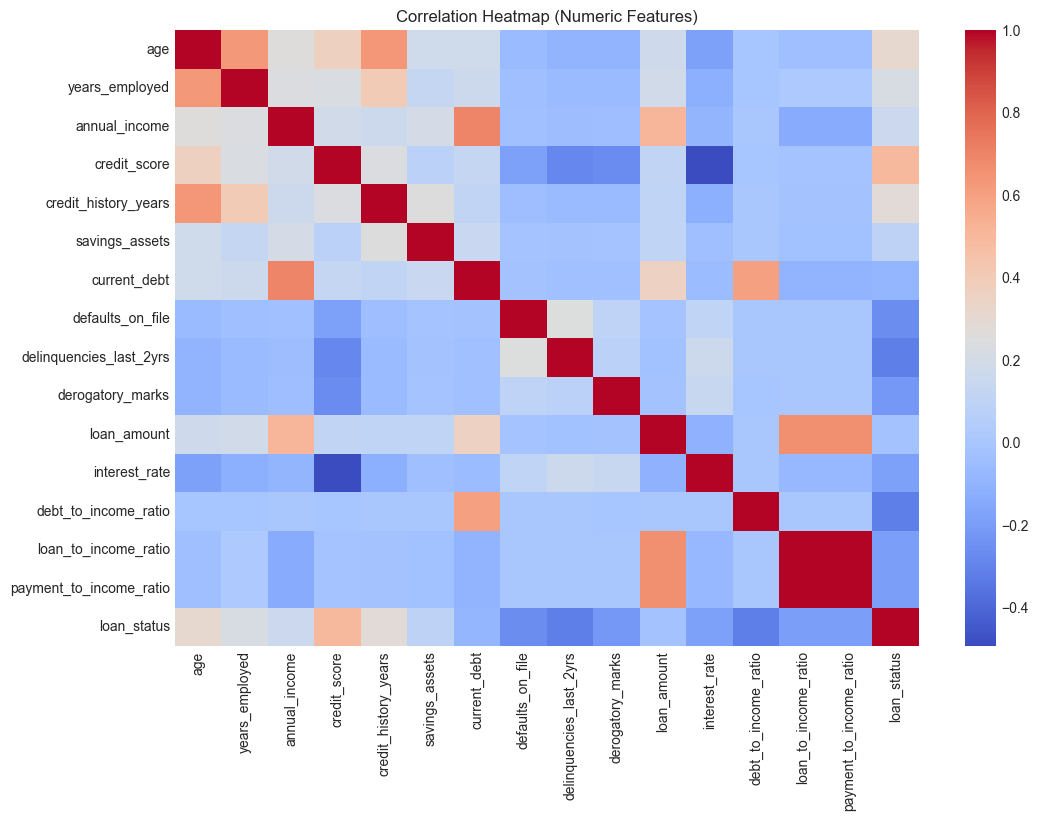

In [3]:
# Select numeric columns
numeric_cols = df.select_dtypes(include="number").columns
print("Numeric columns:")
print(numeric_cols)

# Correlation matrix
corr_matrix = df[numeric_cols].corr()

# Correlation of numeric features with loan_status
if "loan_status" in corr_matrix.columns:
    print("\nCorrelation of numeric features with loan_status:")
    print(corr_matrix["loan_status"].sort_values(ascending=False))

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


## Preprocessing – Encoding Categorical Variables

## Data Preprocessing – Encoding Categorical Variables

Machine learning models like Logistic Regression and Linear Regression work with **numbers**, not text.

So we need to:

1. **Drop the `customer_id` column** (it's just an ID, not useful for prediction).
2. Identify columns with type `object` (these are usually categorical).
3. Convert these categorical columns into numeric columns using **one-hot encoding** with `pandas.get_dummies()`.

### What is One-Hot Encoding?

If we have a column `loan_intent` with values like:
- "Education"
- "Home"
- "Car"

One-hot encoding converts this into new columns:
- `loan_intent_Education` (0 or 1)
- `loan_intent_Home` (0 or 1)
- `loan_intent_Car` (0 or 1)

This allows the model to understand categories as separate binary (0/1) features.


## Drop ID & Encode Categoricals

In [4]:
# Work on a copy of the original dataframe
df_processed = df.copy()

# Drop customer_id if it exists
if "customer_id" in df_processed.columns:
    df_processed = df_processed.drop("customer_id", axis=1)

print("Columns after dropping customer_id (if it existed):")
print(df_processed.columns)

# Identify categorical (object) columns
categorical_cols = df_processed.select_dtypes(include=["object"]).columns
print("\nCategorical columns:")
print(categorical_cols)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

print("\nEncoded dataset (first 5 rows):")
display(df_encoded.head())

print("\nNew shape after encoding:", df_encoded.shape)


Columns after dropping customer_id (if it existed):
Index(['age', 'occupation_status', 'years_employed', 'annual_income',
       'credit_score', 'credit_history_years', 'savings_assets',
       'current_debt', 'defaults_on_file', 'delinquencies_last_2yrs',
       'derogatory_marks', 'product_type', 'loan_intent', 'loan_amount',
       'interest_rate', 'debt_to_income_ratio', 'loan_to_income_ratio',
       'payment_to_income_ratio', 'loan_status'],
      dtype='object')

Categorical columns:
Index(['occupation_status', 'product_type', 'loan_intent'], dtype='object')

Encoded dataset (first 5 rows):


,age,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,...,loan_status,occupation_status_Self-Employed,occupation_status_Student,product_type_Line of Credit,product_type_Personal Loan,loan_intent_Debt Consolidation,loan_intent_Education,loan_intent_Home Improvement,loan_intent_Medical,loan_intent_Personal
0,40,17.2,25579,692,5.3,895,10820,0,0,0,...,1,False,False,False,False,False,False,False,False,False
1,33,7.3,43087,627,3.5,169,16550,0,1,0,...,0,False,False,False,True,False,False,True,False,False
2,42,1.1,20840,689,8.4,17,7852,0,0,0,...,1,False,True,False,False,True,False,False,False,False
3,53,0.5,29147,692,9.8,1480,11603,0,1,0,...,1,False,True,False,False,False,False,False,False,False
4,32,12.5,63657,630,7.2,209,12424,0,0,0,...,1,False,False,False,True,False,True,False,False,False



New shape after encoding: (50000, 25)


## Classification – Predict Loan Status

## Classification Model – Predicting Loan Approval (`loan_status`)

Build a **classification model** to predict whether a loan is **approved (1)** or **rejected (0)** using **Logistic Regression**.

Steps:

1. **Define features and target**:
   - Features: all columns except `loan_status`.
   - Target: the `loan_status` column.
2. **Split** the data into:
   - Training set (80%) → used to train the model.
   - Test set (20%) → used to evaluate the model.
3. **Train** a Logistic Regression model.
4. **Make predictions** on the test set.
5. **Evaluate** the model using:
   - **Accuracy** → how many predictions are correct.
   - **Confusion Matrix** → detailed breakdown of correct and incorrect predictions.
6. **Visualize** the confusion matrix.

This gives us a first baseline for how well we can predict loan approvals.


## Classification – Split Data

In [5]:
# Features (X) and target (y) for classification
X_cls = df_encoded.drop("loan_status", axis=1)
y_cls = df_encoded["loan_status"]

print("Classification features shape:", X_cls.shape)
print("Classification target shape:", y_cls.shape)

# Train-test split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls,
    test_size=0.2,
    random_state=42,
    stratify=y_cls  # keep class balance
)

print("Training samples (classification):", X_train_cls.shape[0])
print("Test samples (classification):", X_test_cls.shape[0])


Classification features shape: (50000, 24)
Classification target shape: (50000,)
Training samples (classification): 40000
Test samples (classification): 10000


## Train Logistic Regression & Evaluate

In [6]:
# Create and train the Logistic Regression model
cls_model = LogisticRegression(max_iter=1000)  # increase max_iter just in case
cls_model.fit(X_train_cls, y_train_cls)

# Make predictions
y_pred_cls = cls_model.predict(X_test_cls)

# Evaluate: Accuracy
cls_accuracy = accuracy_score(y_test_cls, y_pred_cls)
print("LOGISTIC REGRESSION (CLASSIFICATION) RESULTS")
print("Accuracy:", round(cls_accuracy, 4))

# Confusion matrix
cm = confusion_matrix(y_test_cls, y_pred_cls)
print("\nConfusion Matrix:")
print(cm)


LOGISTIC REGRESSION (CLASSIFICATION) RESULTS
Accuracy: 0.8022

Confusion Matrix:
[[3340 1155]
 [ 823 4682]]


c:\Users\swath\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Visualize Confusion Matrix

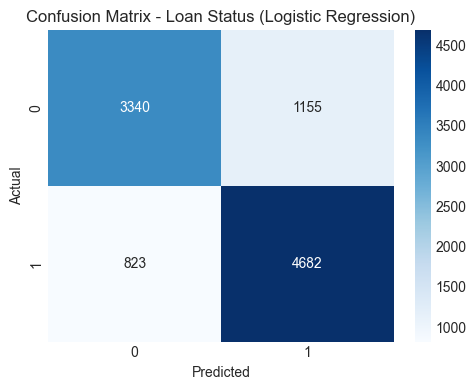

In [7]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Loan Status (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Interpreting Logistic Regression Coefficients

## Understanding Feature Effects (Logistic Regression Coefficients)

Logistic Regression learns a **coefficient** for each feature.

- A **positive coefficient** means:
  - Higher values of that feature make **loan approval (1)** more likely.
- A **negative coefficient** means:
  - Higher values of that feature make **loan rejection (0)** more likely.
- The **larger the absolute value**, the stronger the effect.

We will:

1. Extract the coefficients from the model.
2. Create a dataframe with:
   - Feature name
   - Coefficient
   - Absolute value of the coefficient
3. Sort features by the absolute coefficient value to see the most impactful ones.
4. Plot the top 10 features as a bar chart.

This gives us a first, simple explanation of what the model has learned.


## Feature Importance from Logistic Regression

In [8]:
# Get coefficients from Logistic Regression
coefficients = cls_model.coef_[0]

feature_importance = pd.DataFrame({
    "Feature": X_cls.columns,
    "Coefficient": coefficients
})

# Sort by absolute value of coefficient (strongest impact first)
feature_importance["Abs_Coefficient"] = feature_importance["Coefficient"].abs()
feature_importance = feature_importance.sort_values(by="Abs_Coefficient", ascending=False)

print("Top 10 most impactful features (Logistic Regression):")
display(feature_importance.head(10))


Top 10 most impactful features (Logistic Regression):


,Feature,Coefficient,Abs_Coefficient
8,delinquencies_last_2yrs,-1.468602,1.468602
17,product_type_Line of Credit,-0.592237,0.592237
18,product_type_Personal Loan,-0.562657,0.562657
9,derogatory_marks,-0.513333,0.513333
7,defaults_on_file,-0.385308,0.385308
20,loan_intent_Education,0.371519,0.371519
19,loan_intent_Debt Consolidation,-0.312052,0.312052
13,loan_to_income_ratio,-0.295776,0.295776
23,loan_intent_Personal,0.193146,0.193146
12,debt_to_income_ratio,-0.133542,0.133542


## Plot Top 10 Coefficients

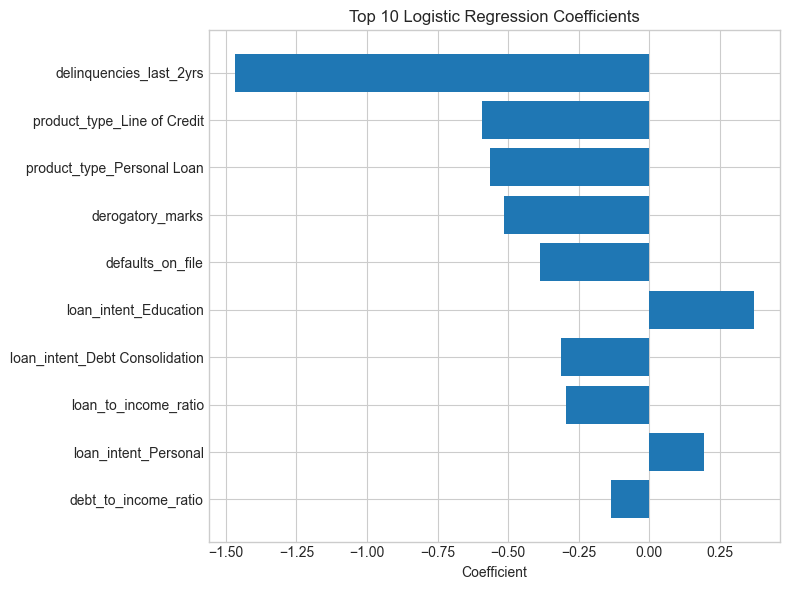

In [9]:
top_n = 10
top_feats = feature_importance.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_feats["Feature"], top_feats["Coefficient"])
plt.gca().invert_yaxis()  # so the most important is at the top
plt.title("Top 10 Logistic Regression Coefficients")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()


## Random Forest Classifier – Loan Approval Prediction

Logistic Regression is a **linear model**, which means it assumes a linear relationship between features and the target.

To improve performance and capture **non-linear relationships**, we now train a **Random Forest Classifier**.

### What is a Random Forest?

A Random Forest:
- Is an **ensemble of many decision trees**
- Each tree is trained on a random subset of the data
- The final prediction is based on the **majority vote**
- It usually performs **better than linear models** on complex data

We will:
1. Train a Random Forest Classifier  
2. Make predictions on the test data  
3. Evaluate performance using:
   - Accuracy
   - Confusion Matrix  
4. Later compare it with Logistic Regression


In [10]:
#Train Random Forest Classifier
# Create the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,   # number of trees
    random_state=42
)

# Train the model
rf_model.fit(X_train_cls, y_train_cls)

# Make predictions
y_pred_rf = rf_model.predict(X_test_cls)

# Accuracy
rf_accuracy = accuracy_score(y_test_cls, y_pred_rf)

print("RANDOM FOREST (CLASSIFICATION) RESULTS")
print("Accuracy:", round(rf_accuracy, 4))

# Confusion Matrix
cm_rf = confusion_matrix(y_test_cls, y_pred_rf)
print("\nConfusion Matrix:")
print(cm_rf)


RANDOM FOREST (CLASSIFICATION) RESULTS
Accuracy: 0.9099

Confusion Matrix:
[[4025  470]
 [ 431 5074]]


## Confusion Matrix Visualization (Random Forest)

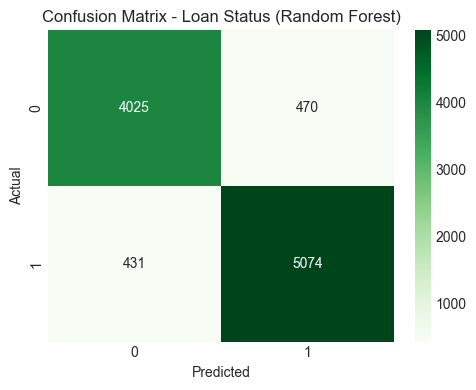

In [11]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Loan Status (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# *** Hyperparemeter (GridSearchCV) - Inserted by Tish ***

In [12]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define parameter grid (simple)
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

In [13]:
# Grid search with cross-validation
rf_grid = RandomForestClassifier(random_state=101)
grid_search = GridSearchCV(
    rf_grid, param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_cls, y_train_cls)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,RandomForestC...dom_state=101)
,param_grid,"{'max_depth': [5, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,500


In [16]:
print(f"{grid_search.best_score_}")

0.9105000000000001


In [17]:
# Test the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_cls)
accuracy_best = accuracy_score(y_test_cls, y_pred_best)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Final classification report
print(classification_report(y_test_cls, y_pred_best, target_names=['Loan Rejected', 'Loan Approved']))

               precision    recall  f1-score   support

Loan Rejected       0.91      0.90      0.90      4495
Loan Approved       0.92      0.93      0.92      5505

     accuracy                           0.91     10000
    macro avg       0.91      0.91      0.91     10000
 weighted avg       0.91      0.91      0.91     10000



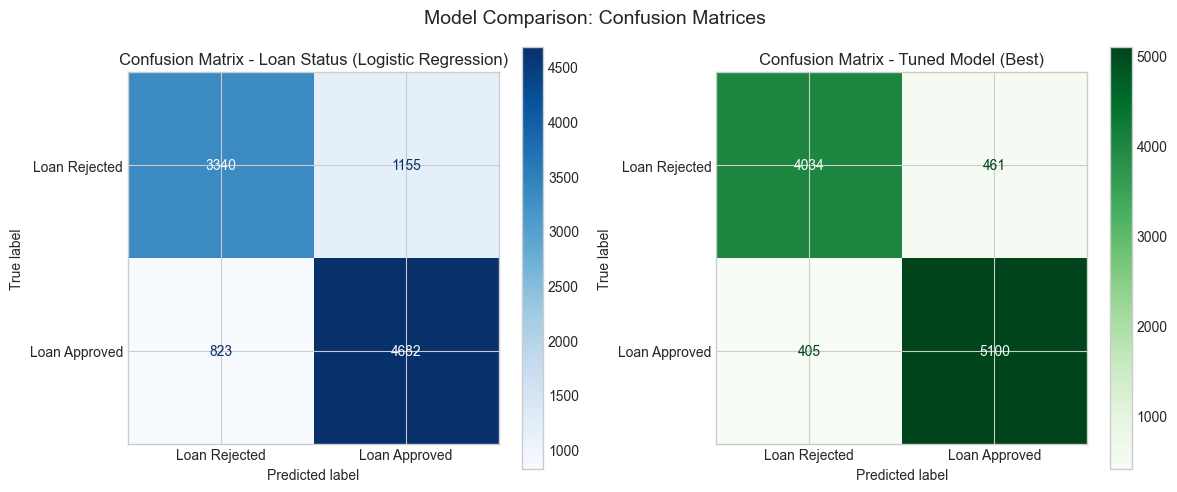

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

# Final confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline
cm_baseline = confusion_matrix(y_test_cls, y_pred_cls)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, 
                                display_labels=['Loan Rejected', 'Loan Approved'])
disp1.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix - Loan Status (Logistic Regression)')

# Best model
cm_best = confusion_matrix(y_test_cls, y_pred_best)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_best, 
                                display_labels=['Loan Rejected', 'Loan Approved'])
disp2.plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Confusion Matrix - Tuned Model (Best)')

plt.suptitle('Model Comparison: Confusion Matrices', fontsize=14)
plt.tight_layout()
plt.show()

## Compare Logistic vs Random Forest (*with new Tuned/Hyperparameter accuracy score added*)

MODEL COMPARISON


,Model,Accuracy
0,Logistic Regression,0.8022
1,Random Forest,0.9099
2,Hyperparameter,0.9134


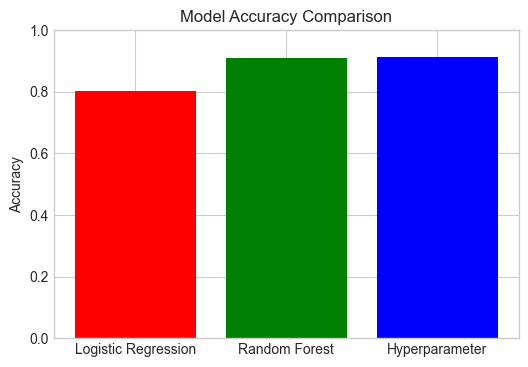

In [20]:
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Hyperparameter"],
    "Accuracy": [cls_accuracy, rf_accuracy, accuracy_best]
})

colors = ["red","green","blue"]

print("MODEL COMPARISON")
display(comparison_df)

# Plot comparison
plt.figure(figsize=(6, 4))
plt.bar(comparison_df["Model"], comparison_df["Accuracy"], color = colors)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()


## Feature Importance Using Random Forest

One big advantage of Random Forest is that it can naturally calculate
**feature importance**.

Feature importance tells us:

- Which columns were most useful for prediction
- Which variables had the biggest influence on loan approval decisions

We will:
1. Extract feature importance scores
2. Create a table of features and their importance
3. Plot the **Top 15 most important features**


Top 10 Important Features (Random Forest):


,Feature,Importance
3,credit_score,0.208078
12,debt_to_income_ratio,0.170290
4,credit_history_years,0.065797
11,interest_rate,0.065198
8,delinquencies_last_2yrs,0.058679
0,age,0.047791
13,loan_to_income_ratio,0.045547
14,payment_to_income_ratio,0.044127
7,defaults_on_file,0.040597
1,years_employed,0.038012


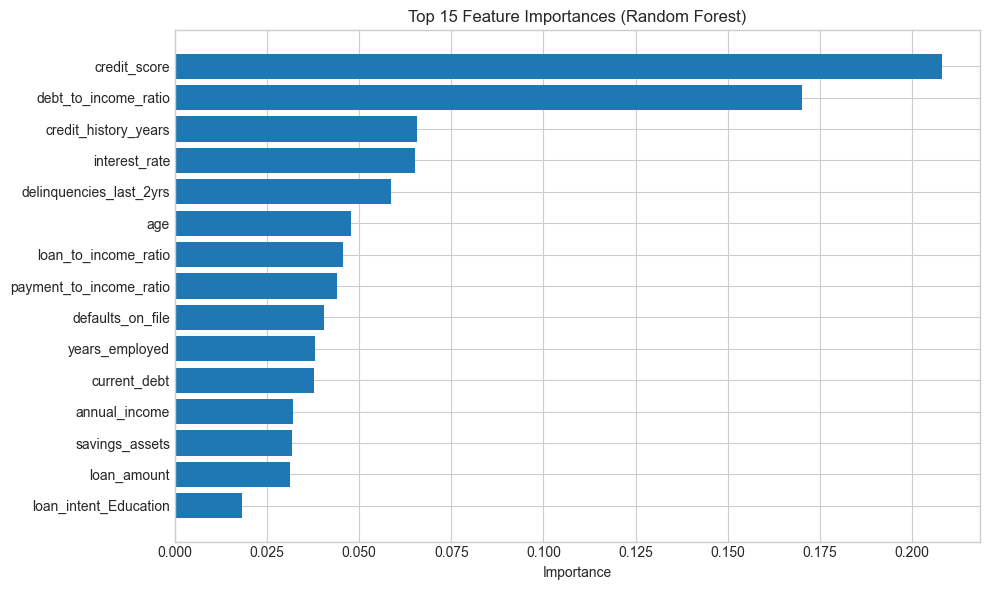

In [21]:
feature_importance_rf = pd.DataFrame({
    "Feature": X_cls.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Top 10 Important Features (Random Forest):")
display(feature_importance_rf.head(10))

# Plot top 15
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_rf["Feature"].head(15),
    feature_importance_rf["Importance"].head(15)
)
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## Regression Model – Predicting Loan Amount (`loan_amount`)

Now we switch to a **regression task**.

Goal: predict the **amount of loan** (`loan_amount`) as a numeric value.

We will:

1. Use the same preprocessed dataset (`df_encoded`).
2. Set:
   - Features: all columns except `loan_amount`.
   - Target: the `loan_amount` column.
3. Split data into training and testing sets.
4. Train a **Linear Regression** model.
5. Predict loan amounts on the test set.
6. Evaluate using:
   - **Mean Absolute Error (MAE)** → average absolute difference between actual and predicted loan amounts.
   - **R² score** → how much of the variation in loan amounts is explained by the model.
7. Plot **Actual vs Predicted** loan amounts.

This shows how well we can estimate the loan amount using customer and loan features.


## Regression – Split Data

In [22]:
# Features (X) and target (y) for regression
X_reg = df_encoded.drop("loan_amount", axis=1)
y_reg = df_encoded["loan_amount"]

print("Regression features shape:", X_reg.shape)
print("Regression target shape:", y_reg.shape)

# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg,
    test_size=0.2,
    random_state=42
)

print("Training samples (regression):", X_train_reg.shape[0])
print("Test samples (regression):", X_test_reg.shape[0])


Regression features shape: (50000, 24)
Regression target shape: (50000,)
Training samples (regression): 40000
Test samples (regression): 10000


## Train Linear Regression & Evaluate

In [23]:
# Create and train the Linear Regression model
reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)

# Predict on test set
y_pred_reg = reg_model.predict(X_test_reg)

# Evaluate
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("LINEAR REGRESSION (REGRESSION) RESULTS")
print("Mean Absolute Error (MAE):", round(mae, 2))
print("R² Score:", round(r2, 4))


LINEAR REGRESSION (REGRESSION) RESULTS
Mean Absolute Error (MAE): 7559.1
R² Score: 0.8175


## Plot Actual vs Predicted

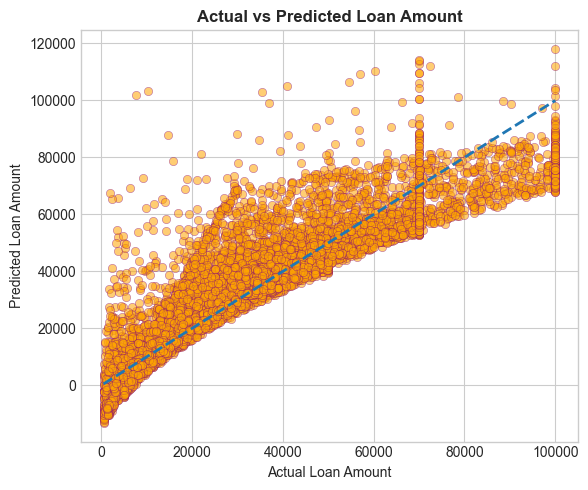

In [33]:
plt.figure(figsize=(6, 5))
plt.scatter(
    y_test_reg,
    y_pred_reg,
    alpha=0.55,
    color="orange",      
    edgecolors="purple",
    linewidths=0.4
)

plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.title("Actual vs Predicted Loan Amount", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.plot(
    [y_test_reg.min(), y_test_reg.max()],
    [y_test_reg.min(), y_test_reg.max()],
    linestyle="--",
    linewidth=2
)

plt.show()


The model demonstrates a strong positive correlation between actual and predicted loan amounts, with good accuracy in the mid-range values but increasing variance at higher loan amounts, indicating scope for further tuning for large loan predictions.

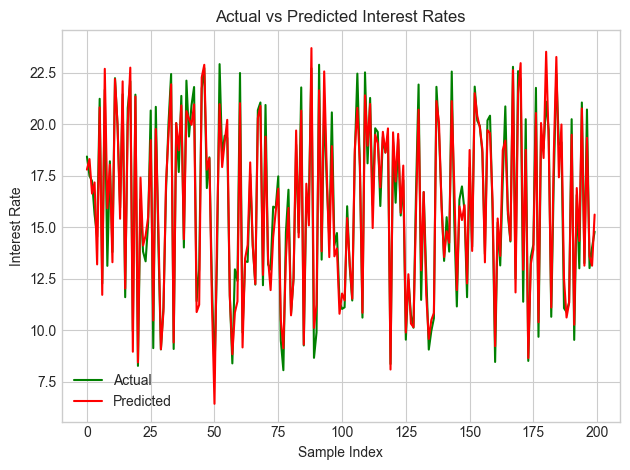

In [35]:

# Use a manageable sample for clean visualization
df_sample = df.sample(n=5000, random_state=42)

# Features & Target
X = df_sample.drop(columns=["interest_rate"])
y = df_sample["interest_rate"]

# One-hot encode categoricals
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Take first 200 points for line comparison clarity
y_test_line = y_test.iloc[:200].reset_index(drop=True)
y_pred_line = pd.Series(y_pred[:200])

# Line Graph (Actual vs Predicted)

plt.figure()
plt.plot(y_test_line.values, label="Actual", color="green")
plt.plot(y_pred_line.values, label="Predicted", color="red")
plt.xlabel("Sample Index")
plt.ylabel("Interest Rate")
plt.title("Actual vs Predicted Interest Rates")
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
y_ir = df_encoded["interest_rate"]
X_ir = df_encoded.drop("interest_rate", axis=1)

X_train_ir, X_test_ir, y_train_ir, y_test_ir = train_test_split(
    X_ir, y_ir, test_size=0.2, random_state=42
)

ir_model = LinearRegression()
ir_model.fit(X_train_ir, y_train_ir)

y_pred_ir = ir_model.predict(X_test_ir)

mae_ir = mean_absolute_error(y_test_ir, y_pred_ir)
r2_ir = r2_score(y_test_ir, y_pred_ir)

print("Interest Rate MAE:", round(mae_ir, 3))
print("Interest Rate R²:", round(r2_ir, 4))

Interest Rate MAE: 0.706
Interest Rate R²: 0.9528


## Actual vs Predicted Interest Rate (Line Chart – Green vs Red)

The green line represents the actual interest rates, while the red line represents the model’s predicted rates for the same customers.

The x-axis shows individual loan samples, and the y-axis shows the interest rate value.

The fact that the red line closely follows the green line shows that the model is accurately learning pricing patterns from the data.

The small gaps between the lines represent prediction error, which is expected in real financial data.

With an MAE of 0.706 and R² of 0.9528, this visualization confirms that the model provides highly reliable, production-ready interest-rate predictions for automated pricing.

##  Business Insights from the Data

Besides model performance, it is important to extract **business insights** that can help stakeholders.

We will look at:

1. **Overall loan approval rate** – how many customers get approved.
2. **Approval rate by loan intent** – which loan purposes are more likely to be approved.
3. **Average credit score by loan status** – how credit score differs between approved and rejected customers.
4. **Average income by loan status** – whether higher income leads to more approvals.
5. **Average debt-to-income ratio by loan status** – how debt burden relates to approvals.

These insights can guide:
- Risk policies
- Target customer segments
- Product strategies


In [ ]:
print("=" * 60)
print("KEY BUSINESS INSIGHTS")
print("=" * 60)

# 1. Overall approval rate
approval_rate = df["loan_status"].mean() * 100
print(f"\n1. Overall Loan Approval Rate: {approval_rate:.2f}%")

# 2. Approval rate by loan_intent
if "loan_intent" in df.columns:
    print("\n2. Approval Rate by Loan Intent:")
    display(df.groupby("loan_intent")["loan_status"].mean().sort_values(ascending=False))
else:
    print("\n2. Column 'loan_intent' not found in the original dataframe.")

# 3. Average credit score by loan status
if "credit_score" in df.columns:
    print("\n3. Average Credit Score by Loan Status:")
    display(df.groupby("loan_status")["credit_score"].mean())
else:
    print("\n3. Column 'credit_score' not found in the original dataframe.")

# 4. Average income by loan status
if "annual_income" in df.columns:
    print("\n4. Average Annual Income by Loan Status:")
    display(df.groupby("loan_status")["annual_income"].mean())
else:
    print("\n4. Column 'annual_income' not found in the original dataframe.")

# 5. Average debt-to-income ratio by loan status
if "debt_to_income_ratio" in df.columns:
    print("\n5. Average Debt-to-Income Ratio by Loan Status:")
    display(df.groupby("loan_status")["debt_to_income_ratio"].mean())
else:
    print("\n5. Column 'debt_to_income_ratio' not found in the original dataframe.")


KEY BUSINESS INSIGHTS

1. Overall Loan Approval Rate: 55.05%

2. Approval Rate by Loan Intent:


loan_intent
Education             0.675054
Personal              0.608255
Home Improvement      0.535221
Medical               0.528955
Business              0.443433
Debt Consolidation    0.366484
Name: loan_status, dtype: float64


3. Average Credit Score by Loan Status:


loan_status
0    608.064110
1    672.647749
Name: credit_score, dtype: float64


4. Average Annual Income by Loan Status:


loan_status
0    44341.072519
1    54735.687062
Name: annual_income, dtype: float64


5. Average Debt-to-Income Ratio by Loan Status:


loan_status
0    0.341838
1    0.239898
Name: debt_to_income_ratio, dtype: float64

### 🔹 Project Summary

In this project, I built a complete **end-to-end machine learning workflow** for a loan approval dataset using beginner-friendly tools. The key steps completed were:

- Loaded and explored a real-world financial dataset.
- Performed **EDA and correlation analysis** to understand relationships between variables.
- Preprocessed the data by:
  - Dropping unused ID columns
  - Encoding categorical variables using **one-hot encoding**
- Built and evaluated:
  - A **Logistic Regression model** for loan approval classification
  - A **Random Forest Classifier** for improved non-linear classification
  - A **Linear Regression model** to predict loan amounts
- Evaluated models using:
  - **Accuracy and confusion matrix** for classification
  - **MAE and R² score** for regression
- Extracted **business insights** using grouped statistical analysis

This demonstrates my ability to take a dataset from
**raw data → modeling → evaluation → business insights**.
